In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow import keras
from tensorflow.keras import layers

использовать упрощенную версию набора данных, где каждый пример отмечен либо 0 (соответствует ненормальному), либо 1 (соответствует нормальному). мы заинтересованы в выявлении ненормальных.

**цифры**

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train.astype('float32') / 255.0, x_test.astype('float32') / 255.0

for i in range (len(y_test)):
  y_test[i]=True
for i in range (len(y_train)):
  y_train[i]=True

#y_test=y_test.astype(bool)
#y_train=y_train.astype(bool)

**Нормализовать данные до [0,1] .**

обучать автоэнкодер, используя только нормальные *, которые в этом наборе данных помечены как 1

In [ ]:
y_test[10]
#[10]-ый элемент - 0

1

**одежда**

In [ ]:
(fashion_x_train, f_y_train), (fashion_x_test, f_y_test) = tf.keras.datasets.fashion_mnist.load_data()

fashion_x_train = fashion_x_train.astype('float32') / 255.
fashion_x_test = fashion_x_test.astype('float32') / 255.

fashion_y_test=[]
fashion_y_train=[]

for i in range (len(f_y_test)):
  fashion_y_test.append(False)
for i in range (len(f_y_train)):
  fashion_y_train.append(False)

In [ ]:
fashion_y_test[1]

False

In [ ]:
normal_train_data = tf.reshape(x_train, [len(x_train), len(x_train[0]) * len(x_train[0][0])])
normal_test_data = tf.reshape(x_test, [len(x_test), len(x_test[0]) * len(x_test[0][0])])
anomalous_train_data = tf.reshape(fashion_x_train, [len(fashion_x_train), len(fashion_x_train[0]) * len(fashion_x_train[0][0])])
anomalous_test_data = tf.reshape(fashion_x_test, [len(fashion_x_test), len(fashion_x_test[0]) * len(fashion_x_test[0][0])])

**vstack() соединяет массивы по вертикали**

>  


**hstack() соединяет массивы по горизонтали**

In [ ]:
test_data = np.vstack((normal_test_data, anomalous_test_data))
test_labels = np.hstack((y_test, fashion_y_test))

**[Построим модель](https://www.tensorflow.org/tutorials/generative/autoencoder#build_the_model)**

In [ ]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(128, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(128, activation="relu"),
      layers.Dense(784, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')
#autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

**автоэнкодер обучается с использованием только обычных *, но оценивается с использованием полного набора тестов.**

In [ ]:
#n=5
n=20
trained_model=autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=n, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
118/118 [==============================] - 1s 6ms/step - loss: 0.1650 - val_loss: 0.1964
Epoch 2/20
118/118 [==============================] - 1s 4ms/step - loss: 0.1192 - val_loss: 0.1927
Epoch 3/20
118/118 [==============================] - 0s 4ms/step - loss: 0.1144 - val_loss: 0.1907
Epoch 4/20
118/118 [==============================] - 1s 4ms/step - loss: 0.1107 - val_loss: 0.1889
Epoch 5/20
118/118 [==============================] - 1s 4ms/step - loss: 0.1079 - val_loss: 0.1879
Epoch 6/20
118/118 [==============================] - 1s 5ms/step - loss: 0.1055 - val_loss: 0.1855
Epoch 7/20
118/118 [==============================] - 1s 4ms/step - loss: 0.1027 - val_loss: 0.1827
Epoch 8/20
118/118 [==============================] - 1s 4ms/step - loss: 0.1005 - val_loss: 0.1805
Epoch 9/20
118/118 [==============================] - 1s 5ms/step - loss: 0.0984 - val_loss: 0.1792
Epoch 10/20
118/118 [==============================] - 1s 4ms/step - loss: 0.0958 - val_loss: 0.1756

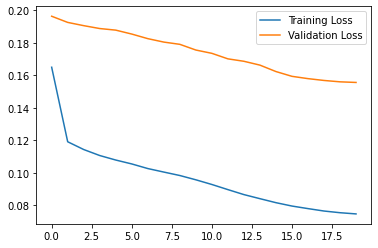

In [ ]:
import matplotlib.pyplot as plt
plt.plot(trained_model.history["loss"], label="Training Loss")
plt.plot(trained_model.history["val_loss"], label="Validation Loss")
plt.legend()

**Постройте ошибку реконструкции из обучающей выборки**

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

**Выберите пороговое значение**

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.1045495


**Классифицируйте * как аномалию, если ошибка восстановления превышает пороговое значение.**

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  
  loss = tf.keras.losses.mae(reconstructions, data)
  #print(loss)
  #print(tf.math.less(loss, threshold))
  #false if > Threshold
  return tf.math.less(loss, threshold)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print("anomaly detection")
print("Accuracy = {}".format(accuracy_score(test_labels, preds)))
print("Precision = {}".format(precision_score(test_labels, preds)))
print("Recall = {}".format(recall_score(test_labels, preds)))

anomaly detection
Accuracy = 0.8869
Precision = 0.9226567620712257
Recall = 0.8446
